# Party on Wall st
I came across the [NYC 311 dataset](https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) which seems like a good place to start the blog. So here it goes: I want to find out how partying in the Financial District is correlated to the stock market movements.

So first thing first, how do you process several GBs of text file on a laptop without rage quitting? Use Spark!  

*new_311_2.csv file was truncated to keep the first 16 columns.*

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
import pandas as pd
sc=SparkContext() 
data = sc.textFile('../new_311_2.csv')

I only wanted to cover the financial district of Manhattan so found the zip codes that cover it, truncate the dataset into smaller, more manageable subset:

In [2]:
fin_zip = ('10004', '10005', '10006', '10028')
csv_data = data.map(lambda x: x.split(", "))
select_data = csv_data.filter(lambda x: x[8] in fin_zip).collect()
headers = csv_data.take(1)
df_fin_zip = pd.DataFrame(select_data)
df_fin_zip.columns = headers

Now adding date as a column, and get a feeling for how actitives was like in the Financial District for that period as baseline:

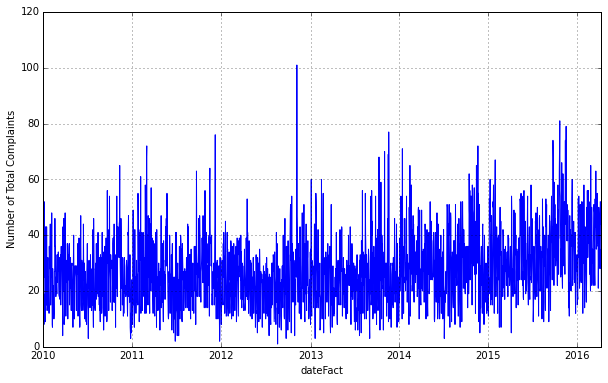

In [400]:
%matplotlib inline 
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 6.0)
df_fin_zip['Created Date'] = pd.to_datetime(df_fin_zip['Created Date'])
df_fin_zip['Closed Date'] = pd.to_datetime(df_fin_zip['Closed Date'])
df_fin_zip['dateFact'] = df_fin_zip['dateFact'].map(lambda x: x.date())
plt = df_fin_zip.groupby(['dateFact'])['Created Date'].count().plot()
plt.set_ylabel("Number of Total Complaints")

Now let's find complains about parties:

In [344]:
print [s for s in df_fin_zip.Descriptor.unique() if 'Party' in s]

[u'Loud Music/Party']


And pick and choose the craziest partying days on Wall st! - days with number of party noise complaints more than 2 standard deviation from normal days. These days are marked by red dashed lines:

Craziest day had 58 complains
Crazy days had at least 7.0 complains
There are 26 crazy party days


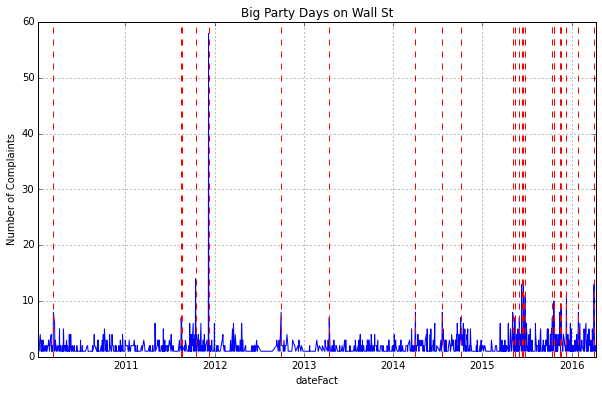

In [458]:
party = df_fin_zip[df_fin_zip.Descriptor == 'Loud Music/Party'].groupby(['dateFact'])['Created Date'].count()
plt1 = party.plot(title='Big Party Days on Wall St')
crazy_party = party[abs(party)>np.mean(party)+2*np.std(party)]
craziest = crazy_party.max()
print 'Craziest day had '+str(craziest)+' complains'
print 'Crazy days had at least '+str(np.ceil(np.mean(party)+2*np.std(party)))+' complains'
print 'There are '+str(crazy_party.count())+' crazy party days'
for dateFact in crazy_party.index:
    plt1.axvline(dateFact, color='r', linestyle='--', lw=1)
plt1.set_ylabel("Number of Complaints")

Some good ole S&P 500 index data for that time period. Interesting metrics are daily gain/loss (close - previous close), and range of movements (daily high - daily low):

In [175]:
from pandas.io.data import DataReader
sp500 = DataReader('^GSPC','yahoo', start = df_fin_zip.dateFact.min(), end = df_fin_zip.dateFact.max())
sp500['Change'] = (sp500['Close'] - sp500.shift(1,freq='D')['Close'])/sp500.shift(1,freq='D')['Close']
sp500['Range'] = (sp500['High'] - sp500['Low'])/sp500['Open']

First I'd like to see whether the parties had anything to do with large gain days, defined as the daily gain greater than 2 standard deviation from the norm on the upside:

There were 26 days with more than 0.02 gains


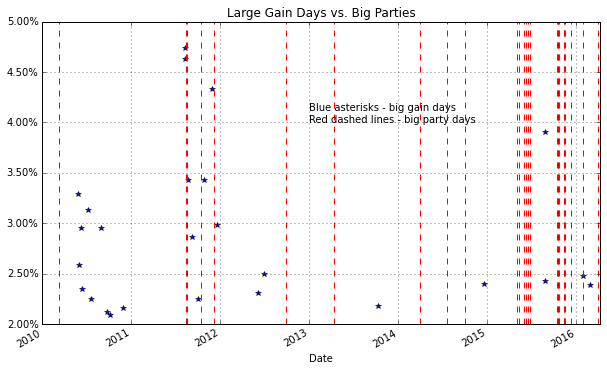

In [443]:
import numpy as np
hi_gain = sp500[sp500.Change>np.mean(sp500.Change)+2*np.std(sp500.Change)]
plt = hi_gain.Change.plot(style='*',xlim=[df_fin_zip.dateFact.min(), df_fin_zip.dateFact.max()],\
                         title='Large Gain Days vs. Big Parties')
vals = plt.get_yticks()
plt.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
for dateFact in crazy_party.index:
    plt.axvline(dateFact, color='r', linestyle='--', lw=1)
print 'There were '+str(hi_gain.High.count())+' days with more than '+ \
str(round(np.mean(sp500.Change)+2*np.std(sp500.Change),2))+ ' gains'
plt.text(pd.datetime(2013,1, 1), 0.04, 'Blue asterisks - big gain days\nRed dashed lines - big party days')

Then we have large loss days, defined as the daily loss greater than 2 standard deviation from the norm on the downside:

There were 41 days with more than -0.02 loss


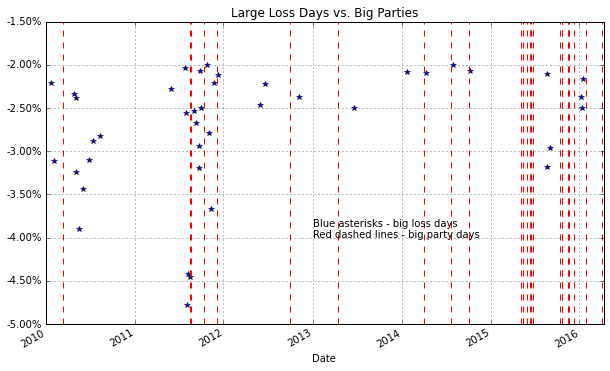

In [439]:
hi_loss = sp500[sp500.Change<np.mean(sp500.Change)-2*np.std(sp500.Change)]
plt = hi_loss.Change.plot(style='*',xlim=[df_fin_zip.dateFact.min(), df_fin_zip.dateFact.max()],\
                         title='Large Loss Days vs. Big Parties')
vals = plt.get_yticks()
plt.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
for dateFact in crazy_party.index:
    plt.axvline(dateFact, color='r', linestyle='--', lw=1, ymin = 0)
print 'There were '+str(hi_loss.High.count())+' days with more than '+ \
str(round(np.mean(sp500.Change)-2*np.std(sp500.Change),2))+ ' loss'
plt.text(pd.datetime(2013,1, 1), -0.04, 'Blue asterisks - big loss days\nRed dashed lines - big party days')

Then the large swing days, defined as the daily range of movement greater than 2 standard deviation from the norm:

There were 65 days with more than 0.026 swing


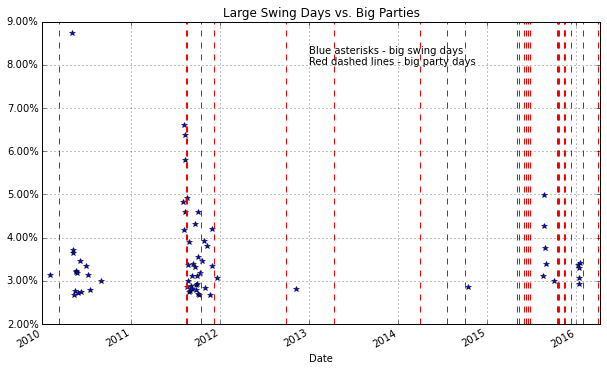

In [444]:
hi_volatility = sp500[abs(sp500.Range)>np.mean(sp500.Range)+2*np.std(sp500.Range)]
plt = hi_volatility.Range.plot(style='*',xlim=[df_fin_zip.dateFact.min(), df_fin_zip.dateFact.max()],\
                         title='Large Swing Days vs. Big Parties')
vals = plt.get_yticks()
plt.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
for dateFact in crazy_party.index:
    plt.axvline(dateFact, color='r', linestyle='--', lw=1)
print 'There were '+str(hi_volatility.High.count())+' days with more than '+ \
str(round(np.mean(sp500.Range)+2*np.std(sp500.Range),3))+ ' swing'
plt.text(pd.datetime(2013,1, 1), 0.08, 'Blue asterisks - big swing days\nRed dashed lines - big party days')

Voila! So we see some incredible cooccurrences of big parties on the street and wild market moves! The big question is, does crazy market drive traders crazy, or do crazy traders drive the market crazy? And how do you get rich off of it?  
If you are a bar owner in the Financial District, stock up alcohol when the market is going nuts; if you are a trader, keep an eye on VIX when fellow traders are going nuts?  
*Disclaimer: I am not a financial advisor and all the above is bullshit. I won't be responsible for your losses.*

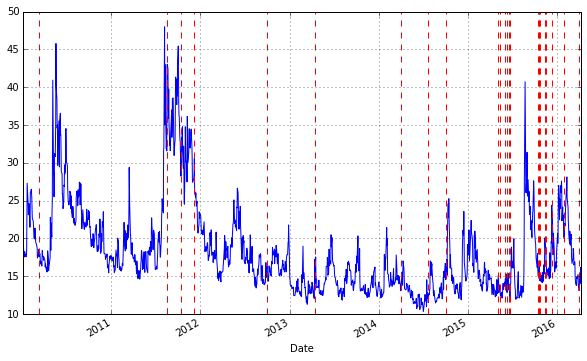

In [459]:
vix = DataReader('^VIX','yahoo', start = df_fin_zip.dateFact.min(), end = df_fin_zip.dateFact.max())
plt = vix.Close.plot()
for dateFact in crazy_party.index:
    plt.axvline(dateFact, color='r', linestyle='--', lw=1)

In [460]:
df_fin_zip.to_pickle('df_fin_zip')